In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd

GRF code

C:\Users\lukas\AppData\Local\Temp\ipykernel_23240\3975701059.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


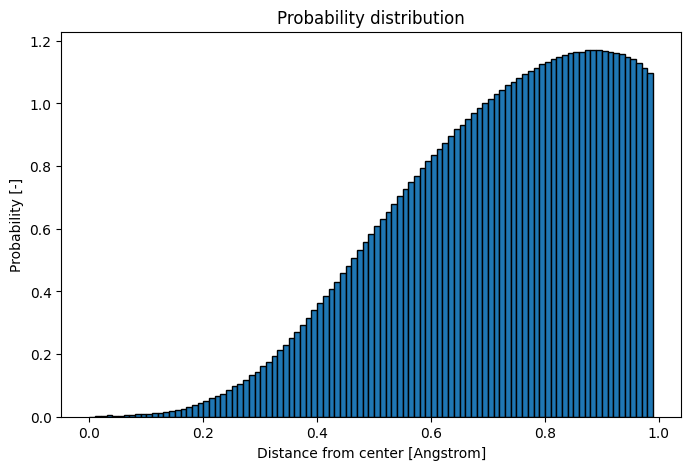

In [2]:
# Load the uploaded file to inspect its structure
file_path = "data/grf_data.dat"

# Try reading as whitespace-separated values
try:
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)
except Exception as e:
    df = str(e)

# Extract x and y from the dataframe
x = df[0].values
y = df[1].values

# Estimate bin edges from midpoints
bin_edges = np.concatenate((
    [x[0] - (x[1] - x[0]) / 2],   # first edge
    (x[:-1] + x[1:]) / 2,         # midpoints
    [x[-1] + (x[-1] - x[-2]) / 2] # last edge
))

# Plot histogram-style bar chart
plt.figure(figsize=(8,5))
plt.bar(x, y, width=np.diff(bin_edges), align='center', edgecolor='black')

plt.xlabel("Distance from center [Angstrom]")
plt.ylabel("Probability [-]")
plt.title("Probability distribution")
plt.show()


Energy conservation B1

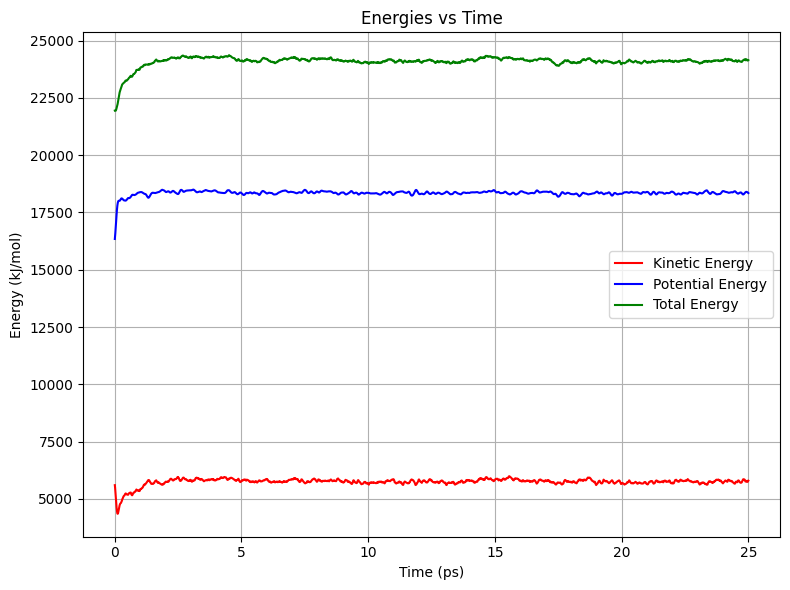

In [3]:
df = pd.read_csv("data/diagnostics.csv")

plt.figure(figsize=(8,6))

# 1) Energies
# Indexing is fucked for some reason, but it works for now so don't touch ;)
plt.plot(df["time"], label="Kinetic Energy", color="red")
plt.plot(df["kinetic_energy"], label="Potential Energy", color="blue")
plt.plot(df["potential_energy"], label="Total Energy", color="green")

plt.ylabel("Energy (kJ/mol)")
plt.xlabel("Time (ps)") 
plt.title("Energies vs Time")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
 

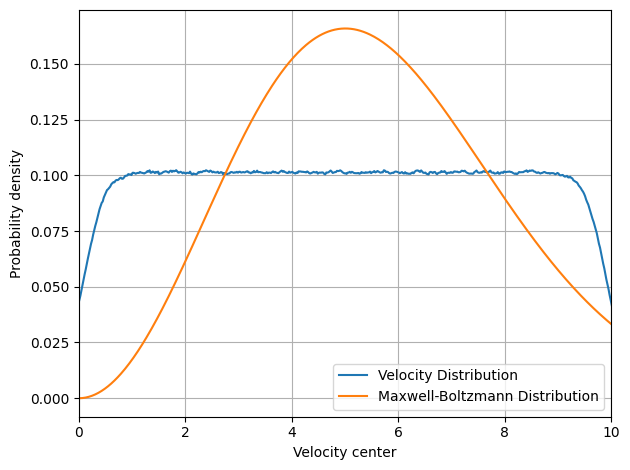

In [ ]:
# --- load data ---
path = "data/vel_histogramB3.csv" 
df = pd.read_csv(path, comment="#", skipinitialspace=True)

v = df["x_center"].to_numpy(float)

# prefer provided PDF; otherwise convert counts -> PDF
if "density" in df.columns:
    density = df["density"].to_numpy(float)
else:
    count = df["count_A"].to_numpy(float)
    binw = np.median(np.diff(v))
    density = count / (count.sum() * binw)

# clean + normalize by area (robust to rounding)
mask = np.isfinite(v) & np.isfinite(density) & (density >= 0)
v = v[mask]
density = density[mask]
density /= np.trapezoid(density, v)

# --- fit MB (m=kB=1) ---
m = 1.0
kB = 1.0
v2 = np.trapezoid(density * v**2, v)  # <v^2>

T3 = m * v2 / (3 * kB)  # 3D
T2 = m * v2 / (2 * kB)  # 2D (for reference)

def mb_3d(x, m, kB, T):
    return ((m/(2*np.pi*kB*T))**1.5) * 4*np.pi * x**2 * np.exp(-m*x**2/(2*kB*T))

mb3 = mb_3d(v, m, kB, T3); mb3 /= np.trapezoid(mb3, v)

# --- plot ---
plt.figure()
plt.plot(v, density, label="Velocity Distribution")
plt.plot(v, mb3, label=f"Maxwell-Boltzmann Distribution")
plt.xlabel("Velocity center")
plt.ylabel("Probability density")
plt.xlim(0,10)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Figures/Velocity_distribution_B3.png")
plt.show()

['x_center', ' density_A', ' density_B', ' density_total']


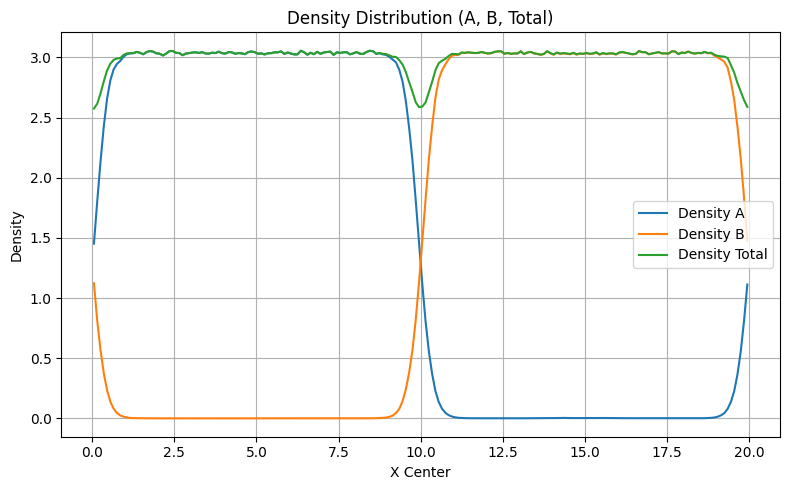

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
file_path = "data/dens_histogramC2.csv"
data = pd.read_csv(file_path)

# Display column names
print(data.columns.tolist())

# Clean column names (strip whitespace)
data.columns = data.columns.str.strip()

# Plot again


plt.figure(figsize=(8, 5))
plt.plot(data["x_center"], data["density_A"], label='Density A')
plt.plot(data["x_center"], data["density_B"], label='Density B')
plt.plot(data["x_center"], data["density_total"], label='Density Total')

plt.xlabel("X Center")
# plt.ylim([0,3])
plt.ylabel("Density")
plt.title("Density Distribution (A, B, Total)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Figures/C2.png")
plt.show()

        Chi   Rho   delta_a   N
0  2.082608   3.0      12.0   1
1  2.130073   3.0      25.0   1
2  2.108740   3.0      15.0   1
3  2.055382   3.0      10.0   1
4  2.009428   3.0       8.0   1


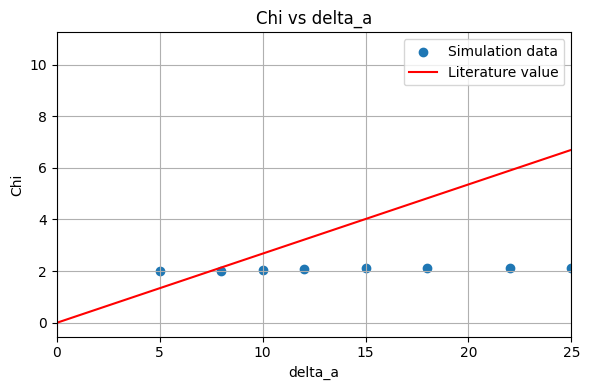

In [17]:
# Load the CSV data
df = pd.read_csv('data/chi_dataC4.csv')

df = df[df[" N"] == 1]

delta_a = np.linspace(0,40,100)
chi_lit = 0.268*delta_a - 0.002

print(df.head())

# Plot Chi vs delta_a
plt.figure(figsize=(6,4))
plt.scatter(df[" delta_a"], df["Chi"], marker='o', label='Simulation data')
plt.plot(delta_a, chi_lit, label="Literature value", color="red")
plt.xlim([0, 25])
plt.xlabel('delta_a')
plt.ylabel('Chi')
plt.title('Chi vs delta_a')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

         Chi   Rho   delta_a   N       new
8   1.061915   3.0      12.0   2  0.176986
9   0.532382   3.0      12.0   4  0.177461
10  0.266410   3.0      12.0   8  0.177607
11  0.709564   3.0      12.0   3  0.177391
12  0.426019   3.0      12.0   5  0.177508


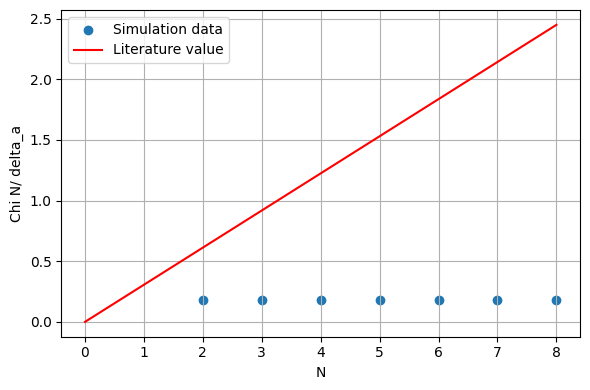

In [18]:
# Load the CSV data
df = pd.read_csv('data/chi_dataC4.csv')

df = df[df[" N"] != 1]

df["new"] = df["Chi"] * df[" N"] / df[" delta_a"]

N = np.linspace(0,8,9)
chi_lit = 0.306*N

print(df.head())

# Plot Chi vs delta_a
plt.figure(figsize=(6,4))
plt.scatter(df[" N"], df["new"], marker='o', label='Simulation data')
plt.plot(N, chi_lit, label="Literature value", color="red")
plt.xlabel('N')
plt.ylabel('Chi N/ delta_a')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()